In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

import simplejson
import json
import math
save = False

# 1. Data Preprocessing

In [2]:
%%time


if not save:
    stock_info_list = pd.read_feather('stock_list.ftr')
else:
    stock_info_list = pd.read_csv('raw/stock_list.csv', parse_dates=['list_date', 'setup_date'])
    stock_info_list.ts_code = stock_info_list.ts_code.apply(lambda x: x[:6])
    stock_info_list = stock_info_list.query('market == "主板" or market == "中小板"')  # Focus only on mainboard and sme, cover all three-level sectors
    stock_info_list = stock_info_list.query('list_date < "2020-01-01"').reset_index(drop=True)  # Remove those got listed too late (171 of them)
    stock_info_list.to_feather('stock_list.ftr')

if not save:
    trade_cal = pd.read_feather('trade_cal.ftr')
else:
    trade_cal = pd.read_csv('raw/trade_cal.csv', parse_dates=['cal_date'])
    trade_cal.to_feather('trade_cal.ftr')

if not save:
    stock_daily = pd.read_feather('stock_daily.ftr')
    stock_daily_log = pd.read_pickle('stock_daily_log.pkl')
else:
    stock_daily = pd.read_feather('raw/stock_price_post_adjusted.ftr')
    stock_daily.ts_code = stock_daily.ts_code.apply(lambda x: x[:6])
    stock_daily = stock_daily[['ts_code', 'trade_date', 'close', 'vol']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    stock_daily = stock_daily.merge(stock_info_list['ts_code'])
    stock_daily_log = stock_daily.pivot_table(values=['close', 'vol'], index='trade_date', columns='ts_code')
    stock_daily_log = np.log(stock_daily_log)
    stock_daily_log = stock_daily_log - stock_daily_log.shift(1)
    
    stock_daily = stock_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    stock_daily.to_feather('stock_daily.ftr')
    stock_daily_log = stock_daily_log.loc['2011-01-01':]
    stock_daily_log.to_pickle('stock_daily_log.pkl')

CPU times: user 295 ms, sys: 243 ms, total: 538 ms
Wall time: 325 ms


In [3]:
%%time

if not save:
    concept_daily = pd.read_feather('concept_daily.ftr')
    concept_daily_log = pd.read_pickle('concept_daily_log.pkl')
else:
    concept_daily = pd.read_csv('raw/concept_daily_list.csv', parse_dates=['trade_date'])[['ts_code', 'trade_date', 'close']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    concept_daily.columns = ['concept_id', 'trade_date', 'close']
    concept_daily_log = concept_daily.pivot_table(values=['close'], index='trade_date', columns='concept_id')
    concept_daily_log = np.log(concept_daily_log)
    concept_daily_log = concept_daily_log - concept_daily_log.shift(1)
    
    concept_daily = concept_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    concept_daily.to_feather('concept_daily.ftr')
    concept_daily_log = concept_daily_log.close.loc['2011-01-01':]
    concept_daily_log.to_pickle('concept_daily_log.pkl')

    
if not save:
    index_daily = pd.read_feather('index_daily.ftr')
    index_daily_log = pd.read_pickle('index_daily_log.pkl')
else:
    index_daily = pd.read_csv('raw/index_daily_list.csv', parse_dates=['trade_date'])[['ts_code', 'trade_date', 'close']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    index_daily.columns = ['in_code', 'trade_date', 'close']
    missing_index_daily = [index_daily]
    for missing_index in ['000988', '000994', '000995']:
        missing_index_df = pd.read_json(f'raw/{missing_index}.json', convert_dates='tradedate')
        missing_index_df['in_code'] = f'{missing_index}.SH'
        missing_index_df['trade_date'] = pd.to_datetime(missing_index_df.tradedate)
        missing_index_df.columns = ['1', '2', 'close', '3', '4', 'in_code', 'trade_date']
        missing_index_daily.append(missing_index_df[['in_code', 'trade_date', 'close']])
    index_daily = pd.concat(missing_index_daily).query('"2010-12-25" <= trade_date <= "2020-12-31"')
    index_daily = index_daily.drop_duplicates(['in_code', 'trade_date'])
    index_daily_log = index_daily.pivot_table(values=['close'], index='trade_date', columns='in_code')
    index_daily_log = np.log(index_daily_log)
    index_daily_log = index_daily_log - index_daily_log.shift(1)
    
    index_daily = index_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    index_daily.to_feather('index_daily.ftr')
    index_daily_log = index_daily_log.close.loc['2011-01-01':]
    index_daily_log.to_pickle('index_daily_log.pkl')

CPU times: user 20.1 ms, sys: 13.8 ms, total: 33.9 ms
Wall time: 29.5 ms


In [4]:
industry_list = pd.read_csv('raw/industry_member_list.csv').rename(columns={'con_code': 'ts_code'})
industry_list.ts_code = industry_list.ts_code.apply(lambda x: x[:6])
industry_list = industry_list.merge(stock_info_list[['ts_code']])
industry_list = industry_list.merge(pd.read_csv('raw/industry_list.csv'))
industry_list = industry_list[['industry_code', 'industry_name', 'level', 'ts_code']]
if save:
    industry_list.to_feather('industry_list.ftr')

index_industry_list = pd.read_csv('raw/index_industry_list.csv')[['ts_code', 'name', 'industry_code']]
index_industry_list.columns = ['in_code', 'name_c', 'industry_code']
index_name_input = pd.Series({
    '000986.SH': 'Energy',
    '000987.SH': 'Materials',
    '000988.SH': 'Industrials',
    '000989.SH': 'Consumer Discretionary',
    '000990.SH': 'Consumer Staples',
    '000991.SH': 'HealthCare',
    '000992.SH': 'Financials',
    '000993.SH': 'IT',
    '000994.SH': 'Telecom',
    '000995.SH': 'Utilities',
}, name='name')
index_industry_list = index_industry_list.merge(index_name_input, left_on='in_code', right_index=True)
if save:
    index_industry_list.to_feather('index_industry_list.ftr')
    
    
concept_list = pd.read_csv('raw/concept_member_list.csv').drop('name', axis=1).merge(pd.read_csv('raw/concept_list.csv').drop('list_date', axis=1))
concept_list.columns = ['concept_code', 'ts_code', 'name']
concept_list.ts_code = concept_list.ts_code.apply(lambda x: x[:6])
concept_list = concept_list.merge(stock_info_list['ts_code'])
if save:
    concept_list.to_feather('concept_list.ftr')

# 2. Correlation networks

In [5]:
%%time

corr_all_years = []

if not save:
    corr_all_years = pd.read_pickle('corr_all_years.pkl')
if save:
    # Takes 15 mins to run
    for year in range(11, 21):
        trade_days = int(trade_cal.query(f'"20{year}-01-01" <= cal_date <= "20{year}-12-31"')['is_open'].sum() * 0.8)
        asset_prices = pd.concat([index_daily_log.loc[f'20{year}-01-01':f'20{year}-12-31']['000001.SH'], stock_daily_log.close.loc[f'20{year}-01-01':f'20{year}-12-31']], axis=1)
        corr_all_years.append(asset_prices.corr(method='spearman', min_periods=trade_days))
    corr_all_years = pd.concat(corr_all_years, axis=1, keys=[f'20{year}' for year in range(11,21)])
    corr_all_years.round(4).to_pickle('corr_all_years.pkl')
    

corr_all_years_no_index = corr_all_years.drop(columns=[(str(year), '000001.SH') for year in range(2011, 2021)]).iloc[1:]
corr_all_years_index = corr_all_years.drop(columns=[(str(year), '000001.SH') for year in range(2011, 2021)]).iloc[1]
corr_all_years

CPU times: user 476 ms, sys: 753 ms, total: 1.23 s
Wall time: 1.23 s


2011                                                        \
          000001.SH  000001 000002  000004 000005  000006  000007  000008   
000001.SH    1.0000  0.6906  0.649  0.5275    NaN  0.6898  0.5537  0.5847   
000001       0.6906  1.0000  0.541  0.2914    NaN  0.5220  0.3091  0.3280   
000002       0.6490  0.5410  1.000  0.2430    NaN  0.6252  0.3230  0.2995   
000004       0.5275  0.2914  0.243  1.0000    NaN  0.4042  0.4124  0.4896   
000005          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
...             ...     ...    ...     ...    ...     ...     ...     ...   
603995          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603996          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603997          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603998          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603999          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   

                          ...    2020                                          \
           000009 000010  ...  603989  603990  603991  603992  603993  603995   
000001.SH  0.5255    NaN  ...  0.5408  0.3919  0.2907  0.3850  0.6418  0.4590   
000001     0.3173    NaN  ...  0.2093  0.1529  0.0066  0.2300  0.3626  0.2339   
000002     0.2896    NaN  ...  0.1051  0.1768 -0.0538  0.1264  0.4227  0.1590   
000004     0.4272    NaN  ...  0.4459  0.3328  0.2182  0.3006  0.2414  0.2611   
000005        NaN    NaN  ...  0.3480  0.2608  0.2792  0.3303  0.3690  0.4244   
...           ...    ...  ...     ...     ...     ...     ...     ...     ...   
603995        NaN    NaN  ...  0.2452  0.1673  0.1871  0.3029  0.3565  1.0000   
603996        NaN    NaN  ...  0.1017  0.1511  0.1729  0.1550  0.1113  0.1896   
603997        NaN    NaN  ...  0.3157  0.2595  0.1559  0.1953  0.4269  0.2176   
603998        NaN    NaN  ...  0.3469  0.2340  0.2810  0.3211  0.3405  0.3566   
603999        NaN    NaN  ...  0.4092  0.3371  0.2796  0.4316  0.4339  0.3475   

                                           
           603996  603997  603998  603999  
000001.SH  0.2322  0.4868  0.5934  0.6498  
000001     0.1034  0.2338  0.2760  0.2984  
000002     0.1202  0.2015  0.2157  0.2083  
000004     0.2525  0.2763  0.2897  0.3997  
000005     0.2533  0.3706  0.4805  0.5590  
...           ...     ...     ...     ...  
603995     0.1896  0.2176  0.3566  0.3475  
603996     1.0000  0.0886  0.2028  0.2578  
603997     0.0886  1.0000  0.3152  0.3736  
603998     0.2028  0.3152  1.0000  0.4858  
603999     0.2578  0.3736  0.4858  1.0000  

[2876 rows x 28760 columns]

In [6]:
def get_index_corr_distribution(year='2011'):
    corr_out = pd.cut(corr_all_years_index[str(year)], bins=[i/100 for i in range(-100, 100, 5)], precision=2, right=True, include_lowest=True).value_counts()
    return [corr_out[i/100] for i in range(-100, 100, 5)]

def get_stock_corr_distribution(query_code='000001', year='2011'):
    corr_out = pd.cut(corr_all_years_no_index[str(year)].loc[query_code], bins=[i/100 for i in range(-100, 100, 5)], precision=2, right=True, include_lowest=True).value_counts()
    return [corr_out[i/100] for i in range(-100, 100, 5)]

query_codes=['000895', '002567', '603363', '002840', '002100']
year='2015'
threshold = 0.68

print(get_index_corr_distribution(year))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 17, 50, 144, 318, 305, 258, 158, 96, 61, 42, 26, 22, 9, 5, 7, 1, 0]


In [7]:
corr_filter = pd.eval('|'.join([f'(corr_all_years_no_index["{str(year)}"]["{query_code}"] > {threshold})' for query_code in query_codes]))
corr_filter = corr_all_years_no_index[year].loc[corr_filter]
corr_filter = corr_filter.filter(items=corr_filter.index)
corr_filter

,000423,000538,000625,000869,000895,002008,002100,002304,002521,600143,...,600327,600486,600660,600738,600809,600811,600887,601607,603077,603167
000423,1.0000,0.7467,0.6741,0.6578,0.6916,0.5608,0.5443,0.6816,0.6118,0.5861,...,0.6071,0.6319,0.7266,0.5350,0.7006,0.6740,0.6375,0.6866,0.5194,0.5258
000538,0.7467,1.0000,0.6116,0.6042,0.6893,0.4620,0.4764,0.6680,0.5678,0.5190,...,0.4996,0.5292,0.6979,0.4518,0.6564,0.6279,0.6196,0.6734,0.5075,0.4831
000625,0.6741,0.6116,1.0000,0.6859,0.6962,0.5097,0.4432,0.6256,0.4457,0.4657,...,0.4629,0.4673,0.7108,0.4110,0.6697,NaN,0.6840,0.6467,NaN,0.5352
000869,0.6578,0.6042,0.6859,1.0000,0.7072,0.5286,0.4850,0.6427,0.5042,0.4784,...,0.5564,0.5193,0.6830,0.4755,0.7245,0.6692,0.6559,0.6383,0.4686,0.5570
000895,0.6916,0.6893,0.6962,0.7072,1.0000,0.4858,0.4831,0.7174,0.5134,0.4638,...,0.5228,0.5294,0.7085,0.4529,0.7128,0.7128,0.6875,0.7117,0.5267,0.5176
002008,0.5608,0.4620,0.5097,0.5286,0.4858,1.0000,0.6820,0.3922,0.7008,0.7042,...,0.7271,0.6503,0.5205,0.6345,0.5796,0.6599,0.4941,0.5737,0.6091,0.6865
002100,0.5443,0.4764,0.4432,0.4850,0.4831,0.6820,1.0000,0.4572,0.6894,0.6880,...,0.6867,0.6983,0.5505,0.6906,0.5556,0.6124,0.4604,0.5394,0.7039,0.6875
002304,0.6816,0.6680,0.6256,0.6427,0.7174,0.3922,0.4572,1.0000,0.4635,0.4007,...,0.4364,0.4739,0.6811,0.3659,0.6868,0.5838,0.6278,0.5611,0.4879,0.4487
002521,0.6118,0.5678,0.4457,0.5042,0.5134,0.7008,0.6894,0.4635,1.0000,0.7034,...,0.6797,0.7074,0.5543,0.6782,0.5988,0.6273,0.4555,0.5903,0.6388,0.6895
600143,0.5861,0.5190,0.4657,0.4784,0.4638,0.7042,0.6880,0.4007,0.7034,1.0000,...,0.7305,0.6629,0.5563,0.6552,0.5617,0.6556,0.4891,0.6002,0.6315,0.6877


In [11]:
%%time

G = nx.from_pandas_adjacency(corr_filter, create_using=nx.Graph)
G.remove_edges_from([(u, v) for (u, v, wt) in G.edges.data('weight') if math.isnan(wt) or wt < threshold or u == v])
# G.remove_nodes_from(list(nx.isolates(G)))
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 55
Average degree:   5.2381
CPU times: user 3.5 ms, sys: 130 µs, total: 3.63 ms
Wall time: 3.57 ms


In [12]:
%%time
modularity_communities = list(nx.algorithms.community.greedy_modularity_communities(G))
modularity_communities

CPU times: user 2.25 ms, sys: 2 µs, total: 2.25 ms
Wall time: 2.26 ms


[frozenset({'002008',
            '002100',
            '002521',
            '600143',
            '600327',
            '600486',
            '600738',
            '603077',
            '603167'}),
 frozenset({'000538', '000625', '000869', '000895', '600660', '600887'}),
 frozenset({'000423', '002304', '600199', '600809', '600811', '601607'})]

In [13]:
%%time

BG = G.copy()
BG.add_edges_from([(u, v, {'weight': 1-wt}) for (u, v, wt) in BG.edges.data('weight')])
print(nx.info(BG))

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 55
Average degree:   5.2381
CPU times: user 619 µs, sys: 106 µs, total: 725 µs
Wall time: 673 µs


In [14]:
betweenness_centrality = nx.algorithms.centrality.betweenness_centrality(BG, endpoints=True, weight='weight')
betweenness_centrality

{'000423': 0.1142857142857143,
 '000538': 0.09523809523809525,
 '000625': 0.09523809523809525,
 '000869': 0.1,
 '000895': 0.38571428571428573,
 '002008': 0.09523809523809525,
 '002100': 0.10952380952380954,
 '002304': 0.09523809523809525,
 '002521': 0.09523809523809525,
 '600143': 0.09523809523809525,
 '600199': 0.24285714285714288,
 '600327': 0.4142857142857143,
 '600486': 0.09523809523809525,
 '600660': 0.10476190476190478,
 '600738': 0.09523809523809525,
 '600809': 0.19523809523809527,
 '600811': 0.4,
 '600887': 0.09523809523809525,
 '601607': 0.09523809523809525,
 '603077': 0.09523809523809525,
 '603167': 0.2285714285714286}

In [15]:
sorted(nx.connected_components(BG), key=len, reverse=True)

[{'000423',
  '000538',
  '000625',
  '000869',
  '000895',
  '002008',
  '002100',
  '002304',
  '002521',
  '600143',
  '600199',
  '600327',
  '600486',
  '600660',
  '600738',
  '600809',
  '600811',
  '600887',
  '601607',
  '603077',
  '603167'}]

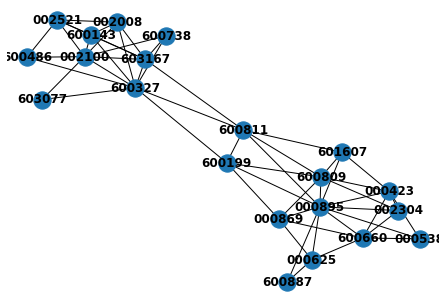

In [16]:
nx.draw(BG, with_labels=True, font_weight='bold')

# Backup

In [4]:
start_date = '2020-01-01'
end_date = '2020-06-30'
query_codes = ['000652', '000538']
features = ['close', 'vol']

display(stock_info_list.merge(pd.Series(query_codes, name='ts_code')))

def corr_community_detection(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe
    stock_price = stock_daily_log.loc[start_date:end_date]
    # filter stock price by 0.8*total trade days in the timeframe
    trade_days = trade_cal.query('@start_date <= cal_date <= @end_date')['is_open'].sum() * 0.8
    trade_days_filter = [(~pd.isna(stock_price.close[column])).sum() > trade_days*0.8 for column in stock_price.close.columns] * 2
    stock_price = stock_price.transpose()[trade_days_filter].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = [stock_price[feature].corrwith(stock_price[feature][query_code], method=method, drop=True) for query_code in query_codes]
        selected_corr.append(pd.DataFrame(selected_stocks, index = query_codes).transpose())
    return pd.concat(selected_corr, axis=1, keys=features)

def corr_community_filter(corr, by='close', threshold=0.5):
    corr_filter = pd.eval('|'.join([f'(corr.{by}["{query_code}"].abs() >{threshold})' for query_code in query_codes]))
    corr_filter = corr[by][corr_filter]
    return list(corr_filter.index)

def corr_matrix(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe and query_codes
    stock_price = stock_daily_log.loc[start_date:end_date]
    stock_price = stock_price.transpose().loc[[(feature, index) for feature in features for index in community_filtered]].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = stock_price[feature].corr(method=method)
        selected_corr.append(selected_stocks)
    return pd.concat(selected_corr, axis=1, keys=features)

,ts_code,symbol,name,area,industry,market,list_date,exchange,chairman,manager,secretary,reg_capital,setup_date,province,city,website,email,employees
0,000538,538,云南白药,云南,中成药,主板,1993-12-15,SZSE,王明辉,董明,吴伟,127740.3317,1993-11-30,云南,昆明市,www.yunnanbaiyao.com.cn,wuwei@yunnanbaiyao.com.cn;ynby@yunnanbaiyao.co...,8124.0
1,000652,652,泰达股份,天津,批发业,主板,1996-11-28,SZSE,张旺,NaN,杨雪晶,147557.3852,1981-08-20,天津,天津市,www.tedastock.com,dm@tedastock.com,1274.0


In [5]:
%%time

community = corr_community_detection(query_codes)

# community.to_pickle('default_community.pkl')
# pd.read_pickle('default_community.pkl')

community

CPU times: user 2.89 s, sys: 5.15 ms, total: 2.89 s
Wall time: 2.89 s


close                 vol          
           000652    000538    000652    000538
ts_code                                        
000001  -0.179678  0.478300 -0.059277  0.300194
000002   0.068529  0.316461 -0.058683  0.086640
000004   0.141784  0.202239  0.237067  0.044177
000005   0.100618  0.331671  0.093684  0.011498
000006  -0.016773  0.392220  0.282457  0.049143
...           ...       ...       ...       ...
603995  -0.118637  0.291249  0.217012  0.018351
603996   0.021339  0.198093  0.126479 -0.050830
603997   0.105330  0.280335  0.170521  0.002206
603998   0.185576  0.550830 -0.087980  0.220290
603999  -0.103473  0.316575  0.253713 -0.056829

[1941 rows x 4 columns]

In [8]:
%%time 
community_filtered = corr_community_filter(community, threshold=0.60)
community_corr = corr_matrix(community_filtered)
community_corr

CPU times: user 48.2 ms, sys: 4.42 ms, total: 52.6 ms
Wall time: 51.6 ms


close                                                              \
ts_code    000078    000538    000623    000652    000955    600200    600269   
ts_code                                                                         
000078   1.000000  0.035032  0.012529  0.663092  0.702619  0.707984 -0.204025   
000538   0.035032  1.000000  0.601262 -0.053648  0.050266 -0.058128  0.608163   
000623   0.012529  0.601262  1.000000  0.006869  0.041916 -0.029609  0.717768   
000652   0.663092 -0.053648  0.006869  1.000000  0.732428  0.626898 -0.063370   
000955   0.702619  0.050266  0.041916  0.732428  1.000000  0.523418 -0.088791   
600200   0.707984 -0.058128 -0.029609  0.626898  0.523418  1.000000 -0.161676   
600269  -0.204025  0.608163  0.717768 -0.063370 -0.088791 -0.161676  1.000000   
600436   0.043507  0.607571  0.632339  0.002157  0.027208 -0.001038  0.450009   
600763  -0.141288  0.607161  0.523916 -0.139085 -0.055724 -0.193452  0.588439   
603288  -0.109988  0.613977  0.387295 -0.109117 -0.071901 -0.148188  0.358486   
603301   0.673205 -0.044781 -0.120289  0.638606  0.621963  0.517123 -0.157888   

                                       ...       vol                      \
ts_code    600436    600763    603288  ...    000538    000623    000652   
ts_code                                ...                                 
000078   0.043507 -0.141288 -0.109988  ...  0.013262  0.073828  0.395098   
000538   0.607571  0.607161  0.613977  ...  1.000000  0.318404 -0.104021   
000623   0.632339  0.523916  0.387295  ...  0.318404  1.000000 -0.085871   
000652   0.002157 -0.139085 -0.109117  ... -0.104021 -0.085871  1.000000   
000955   0.027208 -0.055724 -0.071901  ... -0.079678 -0.085107  0.196820   
600200  -0.001038 -0.193452 -0.148188  ...  0.073617 -0.025144  0.198993   
600269   0.450009  0.588439  0.358486  ...  0.057208  0.339383 -0.069318   
600436   1.000000  0.603788  0.476102  ...  0.446610  0.348596 -0.215245   
600763   0.603788  1.000000  0.604445  ...  0.069614  0.156644 -0.227595   
603288   0.476102  0.604445  1.000000  ...  0.271685  0.229292 -0.133025   
603301   0.004232 -0.125186 -0.143841  ... -0.004495 -0.180357  0.552926   

                                                                               
ts_code    000955    600200    600269    600436    600763    603288    603301  
ts_code                                                                        
000078   0.264872  0.379824 -0.065483 -0.053396 -0.156693 -0.088851  0.543524  
000538  -0.079678  0.073617  0.057208  0.446610  0.069614  0.271685 -0.004495  
000623  -0.085107 -0.025144  0.339383  0.348596  0.156644  0.229292 -0.180357  
000652   0.196820  0.198993 -0.069318 -0.215245 -0.227595 -0.133025  0.552926  
000955   1.000000  0.492683 -0.112160 -0.191208  0.027986 -0.037647  0.286652  
600200   0.492683  1.000000 -0.070253 -0.006323 -0.049913 -0.086094  0.401610  
600269  -0.112160 -0.070253  1.000000  0.098231  0.102912  0.076484 -0.065791  
600436  -0.191208 -0.006323  0.098231  1.000000  0.254041  0.138542 -0.165222  
600763   0.027986 -0.049913  0.102912  0.254041  1.000000  0.289771 -0.243561  
603288  -0.037647 -0.086094  0.076484  0.138542  0.289771  1.000000 -0.164085  
603301   0.286652  0.401610 -0.065791 -0.165222 -0.243561 -0.164085  1.000000  

[11 rows x 22 columns]

# 2. Two-phase hierarchical clustering

In [9]:
def plot_corr(df,size=10):    
    # Plot the correlation matrix
    print(stock_info_list[['ts_code', 'name']].merge(pd.Series(df.columns)).set_index('ts_code').loc[df.columns])
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(cax)
    plt.xticks(range(len(df.columns)), df.columns, rotation=90);
    plt.yticks(range(len(df.columns)), df.columns);
    
def hierarchical_clustering(corr_df, by='close'):
    dist = sch.distance.pdist(corr_df[by].values)
    link = sch.linkage(dist, method='complete')
    index = sch.fcluster(link, dist.max()/2, 'distance')
    columns = corr_df[by].columns.tolist()
    columns = [columns[i] for i in np.argsort(index)]
    return corr_df[by].reindex(columns, axis=0).reindex(columns, axis=1)

def two_phase_hierarchical_clustering(corr_df, first_by='close', second_by='vol'):
    dist = sch.distance.pdist(corr_df[first_by].values)
    link = sch.linkage(dist, method='complete')
    index = sch.fcluster(link, dist.max(initial=0)/2, 'distance')
    columns = corr_df[first_by].columns.tolist()
    columns = [columns[i] for i in np.argsort(index)]
    corr_df_first_hc = corr_df[second_by].reindex(columns, axis=0).reindex(columns, axis=1)
    
    _, counts = np.unique(index, return_counts=True)
    i, j = 0, 0
    columns = []
    for count in counts:
        j += count
        sub_corr_df = corr_df_first_hc[corr_df_first_hc.columns.values[i:j]].loc[corr_df_first_hc.columns.values[i:j]]
        sub_corr_col = sub_corr_df.columns.tolist()
        if j-i > 1:
            dist = sch.distance.pdist(sub_corr_df.values)
            link = sch.linkage(dist, method='complete')
            index = sch.fcluster(link, dist.max(initial=0)/2, 'distance')
            sub_corr_col = [sub_corr_col[ind] for ind in np.argsort(index)]
        i = j
        columns.extend(sub_corr_col)
        
    corr_dfs = [(corr_df[feature].reindex(columns, axis=0).reindex(columns, axis=1)) for feature in features]
    return pd.concat(corr_dfs, axis=1, keys=features)

def combine_corr_matrix(top_right_df, bottom_left_df):
    for idx, col in enumerate(top_right_df.columns):
        bottom_left_df.loc[col][idx:] = top_right_df.loc[col][idx:]
    return bottom_left_df

def find_index_corr(columns, method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe
    index_price = index_daily_log['000001.SH'].loc[start_date:end_date]
    stock_price = stock_daily_log.loc[start_date:end_date].close[columns]
    selected_stocks = stock_price.corrwith(index_price, method=method, drop=True)
    return list(selected_stocks.values)

         name
ts_code      
000078   海王生物
000538   云南白药
000623   吉林敖东
000652   泰达股份
000955   欣龙控股
600200   江苏吴中
600269   赣粤高速
600436    片仔癀
600763   通策医疗
603288   海天味业
603301   振德医疗
         name
ts_code      
000955   欣龙控股
600200   江苏吴中
000078   海王生物
603301   振德医疗
000652   泰达股份
000538   云南白药
600436    片仔癀
000623   吉林敖东
600763   通策医疗
603288   海天味业
600269   赣粤高速
CPU times: user 152 ms, sys: 5.5 ms, total: 158 ms
Wall time: 154 ms


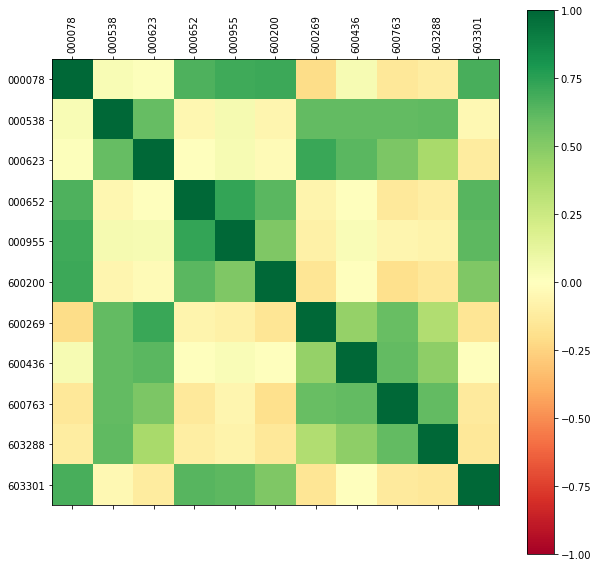

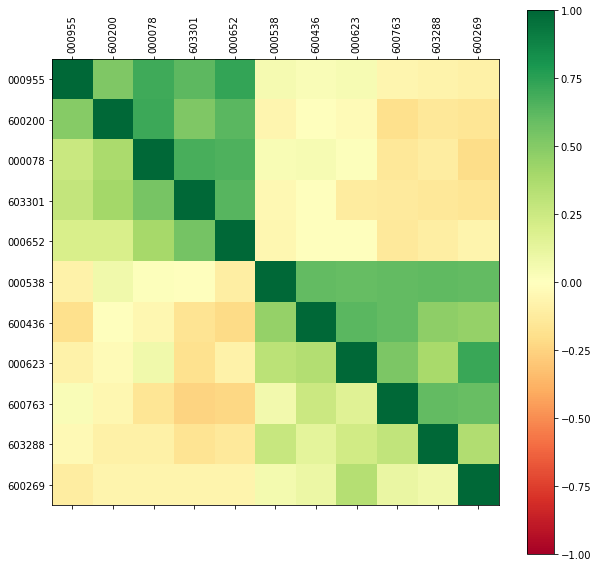

In [10]:
%%time

find_index_corr(community_corr.close.index)

# Pearson correlation matrix with no clustering
# Pearson correlation matrix for the close price between '2020-01-01' and '2020-06-30'
# Queried with ['000652', '000538'] = ['泰达股份', '云南白药'], and correlation threshold set as 0.6
# Resulted with 11 elements
plot_corr(community_corr.close)

community_corr = two_phase_hierarchical_clustering(community_corr)
# Two phase hierarchical_clustering result, first base on close price (log return) then trading volume (log trading volume)
# With price as top-right, trading volume as bottom left
plot_corr(combine_corr_matrix(community_corr.close, community_corr.vol))

# 4. Correlation of different timeframes

In [13]:
start_date = '2020-01-01'
end_date = '2020-06-30'
# start_date = '2011-01-01'
# end_date = '2020-12-31'
query_code = '000652'
# query_code = '000538'
# query_code = '603301'

display(stock_info_list.query('ts_code == @query_code'))

def plot_corr(df,size=10):    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(cax)
    plt.gca().xaxis.tick_bottom()
    plt.xticks(range(len(df.columns)), df.columns, rotation=-90);
    plt.yticks(range(len(df.index)), df.index);

def rolling_corr_market(query_code='000652', start_date='2020-01-01', end_date='2020-06-30'):
    # find appropriate window size
    trade_days = trade_cal.query('@start_date <= cal_date <= @end_date')['is_open'].sum()
    window = int(max(1, trade_days/200))
    
    # filter stock price by timeframe
    index_price = index_daily_log[['000001.SH']].loc[start_date:end_date]
    stock_price = stock_daily_log.close[query_code].loc[start_date:end_date]
    index_stock_price = index_price.merge(stock_price, left_index=True, right_index=True)[::window]
    index_price = index_stock_price[index_stock_price.columns[0]]
    stock_price = index_stock_price[index_stock_price.columns[1]]
    
    # find individual corrlation with market
    pinus = {day: index_price.rolling(day, min_periods=1).corr(stock_price) for day in range(len(index_stock_price), 1, -1)}
    pinus = pd.DataFrame(pinus).round(4).replace([np.inf, -np.inf], np.nan)
    pinus.index = pinus.index.strftime('%Y-%m-%d')
    pinus = pinus.drop(index=pinus.index[0]).transpose() # round to 4dp and drop window size 1 because self correlation is always 1
    return pinus

def find_index_code(query_code='000652'):
    industry_code = industry_member_list.query('ts_code == @query_code and level == "L1"').industry_code.to_list()[0]
    return index_industry_list.query('industry_code == @industry_code').iloc[0]

,ts_code,symbol,name,area,industry,market,list_date,exchange,chairman,manager,secretary,reg_capital,setup_date,province,city,website,email,employees
210,000652,652,泰达股份,天津,批发业,主板,1996-11-28,SZSE,张旺,NaN,杨雪晶,147557.3852,1981-08-20,天津,天津市,www.tedastock.com,dm@tedastock.com,1274.0


In [14]:
%%time
pinus = rolling_corr_market(query_code, start_date, end_date)
pinus

CPU times: user 393 ms, sys: 13.1 ms, total: 406 ms
Wall time: 396 ms


trade_date,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-22,2020-06-23,2020-06-24,2020-06-29,2020-06-30
117,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0700,-0.0700
116,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0700,-0.0693
115,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0693,-0.0693
114,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0693,-0.0693,-0.0693
113,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0686,-0.0693,-0.0693,-0.0710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,-1.0,-0.5213,0.1801,0.7499,0.7730,0.9370,0.9154,0.8998,0.9248,0.9084,...,-0.4942,-0.6653,-0.6672,-0.7300,-0.8671,-0.8524,-0.5592,-0.3958,-0.6515,-0.4859
5,-1.0,-0.5213,0.1801,0.7499,0.9416,0.9476,0.9169,0.9469,0.8974,0.8302,...,-0.4033,-0.7027,-0.7969,-0.8479,-0.8632,-0.6415,-0.3942,-0.4384,-0.7848,-0.2352
4,-1.0,-0.5213,0.1801,0.9911,0.9499,0.9477,0.9917,0.8647,0.8345,0.8568,...,-0.4609,-0.8136,-0.9986,-0.8476,-0.5670,-0.4662,-0.4446,-0.6830,-0.7178,-0.1562
3,-1.0,-0.5213,0.9731,0.9922,0.9496,0.9996,0.9576,0.7624,0.9447,0.8174,...,-0.4241,-0.9993,-0.9997,-0.5440,-0.3845,-0.5107,-0.6828,-0.7748,-0.8642,-0.2442


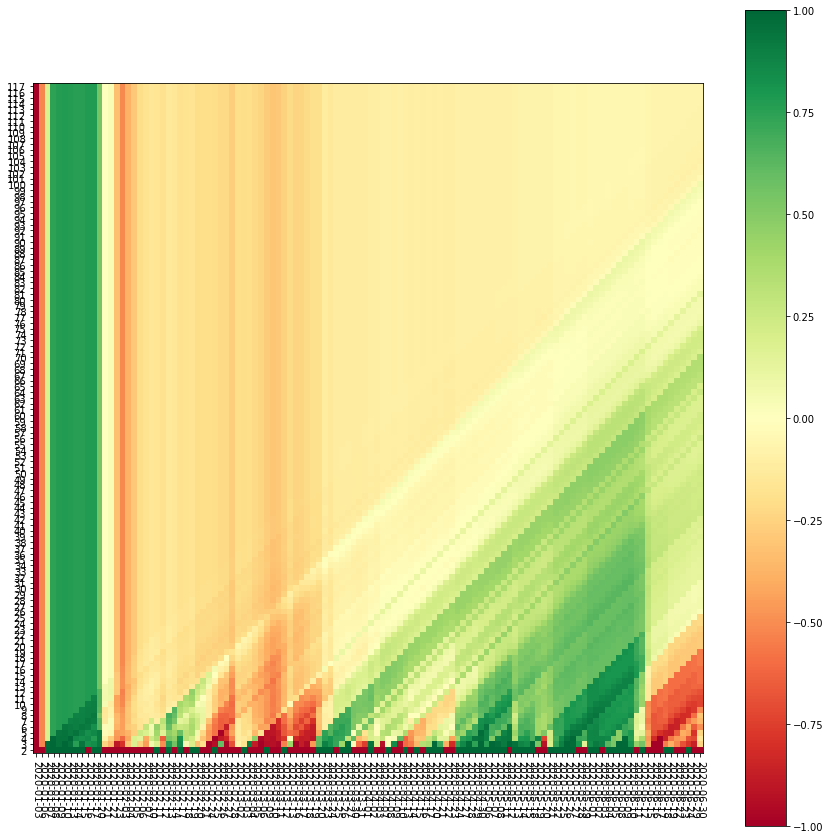

In [15]:
plot_corr(pinus, size=15)

pinus_output = {
    'date': pinus.columns.to_list(),
    'window': pinus.index.to_list(),
    'corr': [i for num, row in pinus.iterrows() for i in row.fillna(2).to_list()[-(len(pinus)+2-num):]]
}
# with open('../../client/src/components/pinus.json', 'w+') as file:
#     simplejson.dump(pinus_output, file, ignore_nan=True)

# pinus_output